<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Load-OD-and-Path-Info" data-toc-modified-id="Load-OD-and-Path-Info-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load OD and Path Info</a></span></li><li><span><a href="#Aggregate-Fuel-Info-by-HRS" data-toc-modified-id="Aggregate-Fuel-Info-by-HRS-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Aggregate Fuel Info by HRS</a></span></li><li><span><a href="#HRS-Size-Bar-Chart" data-toc-modified-id="HRS-Size-Bar-Chart-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>HRS Size Bar Chart</a></span></li></ul></div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load OD and Path Info

In [2]:
OD_info = pd.read_csv('../scratch/OD_info.csv')
OD_info.head()

,orig_node_id,dest_node_id,trip_count,path_id
0,13,18,40940.5,0
1,18,13,40940.5,1
2,12,13,3447.5,2
3,12,18,3447.5,3
4,25,13,245.0,4


In [3]:
Path_fuel_info = pd.read_csv('../scratch/Paths_fuel_km.csv')
Path_fuel_info.head()

,path_id,refuel_at,fuel_km
0,0,18,145.0
1,1,18,120.0
2,3,18,163.0
3,4,51,233.0
4,4,18,104.0


In [4]:
Nodes_info = pd.read_csv('../scratch/Nodes_info.csv')
Nodes_info.head()

,node_id,node_name,rank,lon,lat,latlon_str,latlon_delim_pos,faf_zone,OD,county_long,county_short,County_No
0,1,Redding,1,-122.360642,40.585450,"40.58545,-122.360642",9,Rest of CA,1,Shasta County,Shasta,45
1,2,Red Bluff,1,-122.224084,40.179209,"40.179209,-122.224084",10,Rest of CA,1,Tehama County,Tehama,52
2,3,Dunnigan,2,-121.953458,38.860841,"38.860841,-121.953458",10,None,0,Yolo County,Yolo,57
3,4,Woodland,2,-121.755159,38.689872,"38.689872,-121.755159",10,None,0,Yolo County,Yolo,57
4,5,SMF,1,-121.593640,38.671090,"38.67109,-121.59364",9,Sacramento CA,1,Sacramento County,Sacramento,34


## Aggregate Fuel Info by HRS

In [5]:
from config import LH_FCET_MPkgH2

In [6]:
path_fuel = pd.merge(Path_fuel_info, OD_info, how='left', on='path_id')
path_fuel['fuel_mile'] = path_fuel['fuel_km']/1.609
path_fuel['fuel_kgH2'] = path_fuel['fuel_mile'] / LH_FCET_MPkgH2 * path_fuel['trip_count']
path_fuel.head()

,path_id,refuel_at,fuel_km,orig_node_id,dest_node_id,trip_count,fuel_mile,fuel_kgH2
0,0,18,145.0,13,18,40940.5,90.118086,409942.165596
1,1,18,120.0,18,13,40940.5,74.580485,339262.481873
2,3,18,163.0,12,18,3447.5,101.305158,38805.503764
3,4,51,233.0,25,13,245.0,144.810441,3942.062012
4,4,18,104.0,25,13,245.0,64.636420,1759.546993


In [7]:
hrs_fuel = path_fuel.groupby('refuel_at')[['fuel_kgH2']].sum()
hrs_fuel.rename_axis('hrs_node_id', axis=0, inplace=True)
hrs_fuel.rename(columns={'fuel_kgH2': 'daily_kgH2'}, inplace=True)
hrs_fuel = pd.merge(hrs_fuel, Nodes_info[['node_id', 'node_name']], how='left', left_index=True, right_on='node_id')
hrs_fuel.rename(columns={'node_id':'hrs_node_id'}, inplace=True)
hrs_fuel = hrs_fuel[['hrs_node_id', 'node_name', 'daily_kgH2']]
hrs_fuel.sort_values('daily_kgH2', ascending=False, inplace=True)

In [8]:
hrs_fuel.to_csv('../output/HRS_Daily_kgH2.csv')

## HRS Size Bar Chart

In [9]:
# import seaborn as sns
# print('Seaborn version:', sns.__version__)

In [34]:
plt.style.use('seaborn-paper')

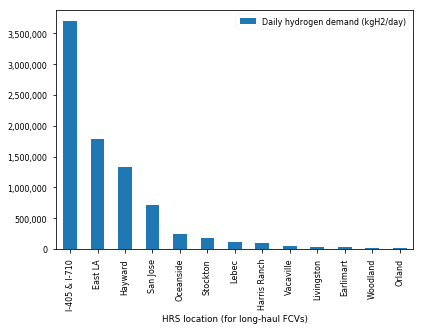

In [35]:
ax = hrs_fuel[['daily_kgH2']].plot.bar()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: '{:,}'.format(int(x))))
ax.set_xticklabels(hrs_fuel.node_name)
ax.set_xlabel('HRS location (for long-haul FCVs)')
ax.legend(['Daily hydrogen demand (kgH2/day)'])

plt.savefig('../visualization/LH HRS Sizes.png', bbox_inches='tight')